In [2]:
# import reuiqred libraries and data loader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from DataLoader import DataLoader
from DataProcessor import DataProcessor

Loader = DataLoader()

In [3]:
df = Loader.load_dataset("C:/Users/PcVip/Downloads/Network_dataset_1.csv", file_type="csv")

2025-08-25 00:54:03,558 - INFO - CSV file loaded successfully:           src_ip  src_port         dst_ip  dst_port proto service  \
0    3.122.49.24      1883  192.168.1.152     52976   tcp       -   
1   192.168.1.79     47260  192.168.1.255     15600   udp       -   
2  192.168.1.152      1880  192.168.1.152     51782   tcp       -   
3  192.168.1.152     34296  192.168.1.152     10502   tcp       -   
4  192.168.1.152     46608  192.168.1.190        53   udp     dns   

       duration src_bytes  dst_bytes conn_state  ...  http_response_body_len  \
0  80549.530260   1762852   41933215        OTH  ...                       0   
1      0.000000         0          0         S0  ...                       0   
2      0.000000         0          0        OTH  ...                       0   
3      0.000000         0          0        OTH  ...                       0   
4      0.000549         0        298        SHR  ...                       0   

   http_status_code  http_user_agent  htt

In [4]:
df.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,3.122.49.24,1883,192.168.1.152,52976,tcp,-,80549.530260,1762852,41933215,OTH,...,0,0,-,-,-,bad_TCP_checksum,-,F,0,normal
1,192.168.1.79,47260,192.168.1.255,15600,udp,-,0.000000,0,0,S0,...,0,0,-,-,-,-,-,-,0,normal
2,192.168.1.152,1880,192.168.1.152,51782,tcp,-,0.000000,0,0,OTH,...,0,0,-,-,-,bad_TCP_checksum,-,F,0,normal
3,192.168.1.152,34296,192.168.1.152,10502,tcp,-,0.000000,0,0,OTH,...,0,0,-,-,-,-,-,-,0,normal
4,192.168.1.152,46608,192.168.1.190,53,udp,dns,0.000549,0,298,SHR,...,0,0,-,-,-,bad_UDP_checksum,-,F,0,normal


In [5]:
df["type"].value_counts()

type
scanning    791321
normal      208679
Name: count, dtype: int64

In [6]:
df = Loader.clean_dataset(df)

2025-08-25 00:54:04,741 - INFO - Dataset cleaned successfully. 124934 rows have been removed.


In [ ]:
df["type"].value_counts()

In [ ]:
# Show dataframe columns
df.columns

In [ ]:
# We take onlu the following columns
features = [
    "duration", 
    "src_bytes", "dst_bytes", 
    "src_pkts", "dst_pkts"
]

X = df[features]
y = df["label"].astype("Int64")

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
for col in ["duration", "src_bytes", "dst_bytes", "src_pkts", "dst_pkts",
            "src_ip_bytes", "dst_ip_bytes"]:
    X[col] = pd.to_numeric(X[col], errors="coerce")

# divide categorial and numerical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

In [ ]:
print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

In [ ]:
# import data processor
processor = DataProcessor(num_cols=num_cols, cat_cols=cat_cols)

In [ ]:
from sklearn.model_selection import StratifiedKFold
# Define the outer and inner cross-validation strategies
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    matthews_corrcoef, brier_score_loss, confusion_matrix,
    classification_report
)
from sklearn.base import clone
import numpy as np
import pandas as pd

best_models = {
    "XGBoost": Pipeline([
        ("pre", DataProcessor(num_cols, cat_cols)),
        ("select", SelectKBest(score_func=f_classif, k=4)),
        ("clf", XGBClassifier(eval_metric="logloss", n_estimators=100, max_depth=5, learning_rate=0.1))
    ]),
    "RandomForest": Pipeline([
        ("pre", DataProcessor(num_cols, cat_cols)),
        ("select", SelectKBest(score_func=f_classif, k=4)),
        ("clf", RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2))
    ]),
    "MLPClassifier": Pipeline([
        ("pre", DataProcessor(num_cols, cat_cols)),
        ("select", SelectKBest(score_func=f_classif, k=5)),
        ("clf", MLPClassifier(hidden_layer_sizes=(50,), activation="relu", alpha=0.0001, max_iter=500, random_state=42))
    ])
}

results = []
for model_name, pipeline in best_models.items():
    print(f"\nEvaluando {model_name}...")

    outer_scores = {"f1": [], "roc_auc": [], "auprc": [], "mcc": [], "brier": [], "fnr": []}
    confusion_matrixes, classification_reports = [], []
    selected_features_folds = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(pipeline)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        outer_scores["f1"].append(f1_score(y_test, y_pred))
        outer_scores["roc_auc"].append(roc_auc_score(y_test, y_proba))
        outer_scores["auprc"].append(average_precision_score(y_test, y_proba))
        outer_scores["mcc"].append(matthews_corrcoef(y_test, y_pred))
        outer_scores["brier"].append(brier_score_loss(y_test, y_proba))

        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        outer_scores["fnr"].append(fnr)
        confusion_matrixes.append(cm)

        report = classification_report(
            y_test, y_pred,
            target_names=["Benigno (0)", "Malicioso (1)"],
            output_dict=True
        )
        classification_reports.append(report)

        # === Guardar features seleccionadas en este fold ===
        select_step = model.named_steps["select"]
        feature_names = model.named_steps["pre"].get_feature_names_out()
        selected_mask = select_step.get_support()
        selected_features = feature_names[selected_mask]
        selected_features_folds.append(list(selected_features))

    results.append({
        "Modelo": model_name,
        "F1": f"{np.mean(outer_scores['f1']):.3f} ± {np.std(outer_scores['f1']):.3f}",
        "ROC-AUC": f"{np.mean(outer_scores['roc_auc']):.3f} ± {np.std(outer_scores['roc_auc']):.3f}",
        "AUPRC": f"{np.mean(outer_scores['auprc']):.3f} ± {np.std(outer_scores['auprc']):.3f}",
        "MCC": f"{np.mean(outer_scores['mcc']):.3f} ± {np.std(outer_scores['mcc']):.3f}",
        "Brier": f"{np.mean(outer_scores['brier']):.3f} ± {np.std(outer_scores['brier']):.3f}",
        "FNR": f"{np.mean(outer_scores['fnr']):.3f} ± {np.std(outer_scores['fnr']):.3f}",
        "ConfusionMatrix_por_fold": confusion_matrixes,
        "ClassificationReport_por_fold": classification_reports,
        "BestFeatures_por_fold": selected_features_folds
    })

df_results = pd.DataFrame(results)
print("\nResultados finales:")
print(df_results[["Modelo", "F1", "ROC-AUC", "AUPRC", "MCC", "Brier", "FNR"]])

# === Contar qué features se repiten más por modelo ===
for _, row in df_results.iterrows():
    modelo = row["Modelo"]
    features_folds = row["BestFeatures_por_fold"]
    all_feats = [feat for fold_feats in features_folds for feat in fold_feats]
    feat_counts = pd.Series(all_feats).value_counts()
    print(f"\n{modelo} - Features más seleccionadas:")
    print(feat_counts)


In [7]:
df_prep = df.copy()

In [8]:
num_features = ["duration","src_bytes","dst_bytes",
                "src_pkts","dst_pkts","src_ip_bytes","dst_ip_bytes"]
cat_features = ["proto","conn_state","service"]

In [9]:
for col in num_features:
    df_prep[col] = pd.to_numeric(df_prep[col], errors="coerce").fillna(0)

In [10]:
scaler = StandardScaler()
X_num = scaler.fit_transform(df_prep[num_features])


In [15]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = ohe.fit_transform(df_prep[cat_features].astype(str))



In [16]:
print(X_num.shape, X_cat.shape)
# Ej: (10000, 7) (10000, 25)


(875066, 7) (875066, 36)


In [17]:
X_num = np.array(X_num)
X_cat = np.array(X_cat)

print(X_num.shape, X_cat.shape, type(X_num), type(X_cat))

X_all = np.hstack([X_num, X_cat])

y_all = df_prep["label"].values

(875066, 7) (875066, 36) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [18]:
def create_sequences(X, y, window_size=10):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:(i + window_size)])
        ys.append(y[i + window_size])  # etiqueta del último elemento
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_all, y_all, window_size=10)

print("Shape secuencias:", X_seq.shape, y_seq.shape)

Shape secuencias: (875056, 10, 43) (875056,)


In [19]:
import numpy as np
unique, counts = np.unique(y_seq, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(83830), np.int64(1): np.int64(791226)}


In [20]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


In [25]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print(class_weights)




model = Sequential([
    GRU(64, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=256,
    class_weight=class_weights
)


{np.int64(0): np.float64(4.181514090816777), np.int64(1): np.float64(0.5679068431718362)}


c:\Users\PcVip\deteccion-botnets-tfm\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9816 - loss: 0.0926 - val_accuracy: 0.9992 - val_loss: 0.0329
Epoch 2/5
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9815 - loss: 0.0861 - val_accuracy: 0.9976 - val_loss: 0.0626
Epoch 3/5
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9817 - loss: 0.0856 - val_accuracy: 0.9987 - val_loss: 0.0503
Epoch 4/5
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9818 - loss: 0.0851 - val_accuracy: 0.9979 - val_loss: 0.0517
Epoch 5/5
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9818 - loss: 0.0849 - val_accuracy: 0.9990 - val_loss: 0.0407


In [28]:
# Probabilidades
y_proba = model.predict(X_test, batch_size=256)

# Convertir a 0/1 con umbral 0.5
y_pred = (y_proba > 0.75).astype("int32").flatten()


684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[[     0    123]
 [   511 174378]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       123
           1     0.9993    0.9971    0.9982    174889

    accuracy                         0.9964    175012
   macro avg     0.4996    0.4985    0.4991    175012
weighted avg     0.9986    0.9964    0.9975    175012

ROC-AUC: 0.5461890182888129


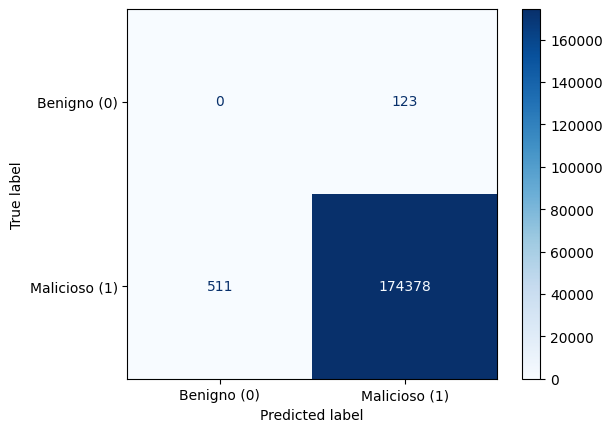

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
# display the confusion matrix with ConfussionMatrxixDisplay
cm = confusion_matrix(y_test, y_pred)
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benigno (0)", "Malicioso (1)"])
disp.plot(cmap=plt.cm.Blues)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import resample, class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, matthews_corrcoef
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# ============================
# Balanceo del dataset
# ============================
# Aplano para poder hacer oversampling
X_train_flat = X_train.reshape(X_train.shape[0], -1)
df_train = pd.DataFrame(X_train_flat)
df_train["label"] = y_train

# Separar clases
df_majority = df_train[df_train.label == 1]
df_minority = df_train[df_train.label == 0]

print("Antes del balanceo:", len(df_majority), "ataques,", len(df_minority), "normales")

# Oversample clase 0
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# Dataset balanceado
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Reconstruir arrays
y_train_bal = df_balanced["label"].values
X_train_bal = df_balanced.drop(columns=["label"]).values.reshape(-1, X_train.shape[1], X_train.shape[2])

print("Después del balanceo:", np.bincount(y_train_bal))

# ============================
# Pesos de clase (por si queda algo de desbalanceo)
# ============================
classes = np.unique(y_train_bal)
weights = class_weight.compute_class_weight(class_weight="balanced", classes=classes, y=y_train_bal)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

# ============================
# Modelo GRU
# ============================
model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train_bal, y_train_bal,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=256,
    class_weight=class_weights,
    verbose=1
)

# ============================
# Evaluación
# ============================
y_proba = model.predict(X_test, batch_size=256)
y_pred = (y_proba > 0.5).astype("int32").flatten()

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("F1:", f1_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))



Antes del balanceo: 616337 ataques, 83707 normales
Después del balanceo: [616337 616337]
Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}


c:\Users\PcVip\deteccion-botnets-tfm\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9727 - loss: 0.0889 - val_accuracy: 0.9992 - val_loss: 0.0274
Epoch 2/5
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9735 - loss: 0.0843 - val_accuracy: 0.9981 - val_loss: 0.0489
Epoch 3/5
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9737 - loss: 0.0836 - val_accuracy: 0.9988 - val_loss: 0.0391
Epoch 4/5
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9740 - loss: 0.0829 - val_accuracy: 0.9986 - val_loss: 0.0409
Epoch 5/5
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9743 - loss: 0.0823 - val_accuracy: 0.9986 - val_loss: 0.0446
684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Confusion matrix:
 [[     0    123]
 [   121 174768]]

Classification report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       123
           1     0.9993    0.9993    0.9993    174889

    accuracy                         0.9986    175012
   macro av

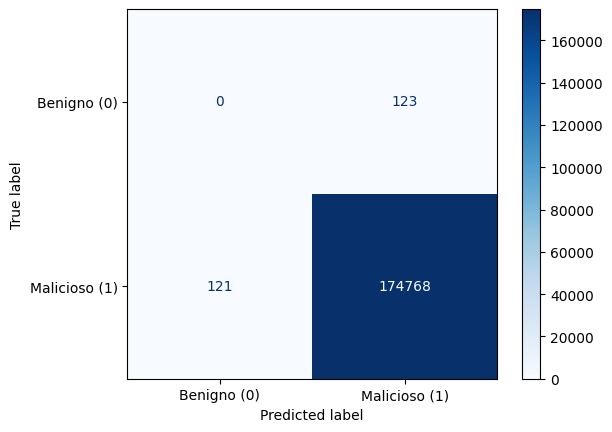

In [ ]:
# Confussion matrix display of y_pred and y_test
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Display the confusion matrix with ConfussionMatrxixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benigno (0)", "Malicioso (1)"])
disp.plot(cmap=plt.cm.Blues)

Original balance: [ 83707 616337]
Balance después de SMOTE: [616337 616337]


c:\Users\PcVip\deteccion-botnets-tfm\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9724 - loss: 0.0185 - val_accuracy: 0.9993 - val_loss: 0.0082
Epoch 2/5
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.9777 - loss: 0.0153 - val_accuracy: 0.9965 - val_loss: 0.0101
Epoch 3/5
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - accuracy: 0.9826 - loss: 0.0128 - val_accuracy: 0.9903 - val_loss: 0.0148
Epoch 4/5
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9836 - loss: 0.0123 - val_accuracy: 0.9991 - val_loss: 0.0076
Epoch 5/5
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - accuracy: 0.9849 - loss: 0.0116 - val_accuracy: 0.9988 - val_loss: 0.0084
684/684 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Confusion matrix:
 [[     0    123]
 [    91 174798]]

Classification report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       123
           1     0.9993    0.9995    0.9994    174889

    accuracy                         0.9988    175012
   macro av

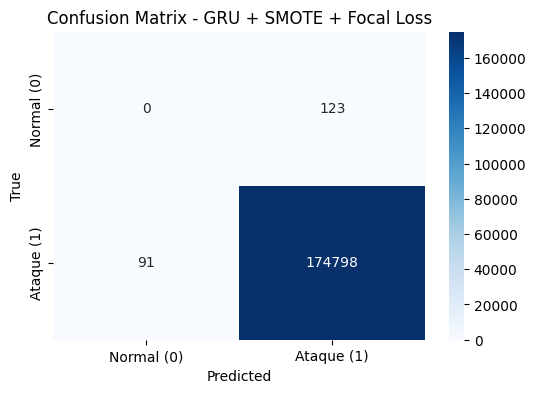

In [35]:
! pip install imbalanced-learn
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# ============================
# SMOTE para balancear dataset
# ============================
print("Original balance:", np.bincount(y_train))

# Flatten para SMOTE
n_samples, timesteps, n_features = X_train.shape
X_train_flat = X_train.reshape((n_samples, timesteps * n_features))

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_flat, y_train)

# Reconstruir 3D para GRU
X_train_bal = X_train_bal.reshape((-1, timesteps, n_features))
print("Balance después de SMOTE:", np.bincount(y_train_bal))

# ============================
# Focal Loss
# ============================
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-bce)
        return alpha * (1 - pt) ** gamma * bce
    return loss

# ============================
# Modelo GRU
# ============================
model = Sequential([
    GRU(64, input_shape=(timesteps, n_features)),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(1e-3),
    loss=focal_loss(gamma=2., alpha=0.75),
    metrics=["accuracy"]
)

history = model.fit(
    X_train_bal, y_train_bal,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=256,
    verbose=1
)

# ============================
# Evaluación
# ============================
y_proba = model.predict(X_test, batch_size=256)
y_pred = (y_proba > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("F1:", f1_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))

# ============================
# Visualizar matriz de confusión
# ============================
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal (0)","Ataque (1)"], yticklabels=["Normal (0)","Ataque (1)"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GRU + SMOTE + Focal Loss")
plt.show()


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

model = Sequential([
    GRU(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3,
        input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(32, dropout=0.3, recurrent_dropout=0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",  # puedes probar focal loss aquí
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

early_stop = EarlyStopping(monitor="val_auc", patience=3, restore_best_weights=True)

history = model.fit(
    X_train_bal, y_train_bal,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=256,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

c:\Users\PcVip\deteccion-botnets-tfm\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 48s 9ms/step - accuracy: 0.9701 - auc: 0.9871 - loss: 0.0988 - val_accuracy: 0.9989 - val_auc: 0.5048 - val_loss: 0.0378
Epoch 2/20
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9726 - auc: 0.9884 - loss: 0.0891 - val_accuracy: 0.9992 - val_auc: 0.5075 - val_loss: 0.0430
Epoch 3/20
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.9737 - auc: 0.9889 - loss: 0.0865 - val_accuracy: 0.9991 - val_auc: 0.4618 - val_loss: 0.0418
Epoch 4/20
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.9749 - auc: 0.9894 - loss: 0.0834 - val_accuracy: 0.9981 - val_auc: 0.4741 - val_loss: 0.0451
Epoch 5/20
4816/4816 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.9759 - auc: 0.9899 - loss: 0.0807 - val_accuracy: 0.9988 - val_auc: 0.4747 - val_loss: 0.0414


684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Confusion matrix:
 [[     0    123]
 [    18 174871]]

Classification report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       123
           1     0.9993    0.9999    0.9996    174889

    accuracy                         0.9992    175012
   macro avg     0.4996    0.4999    0.4998    175012
weighted avg     0.9986    0.9992    0.9989    175012

ROC-AUC: 0.4731677890742964
F1: 0.999597008142722
MCC: -0.0002689651314461298


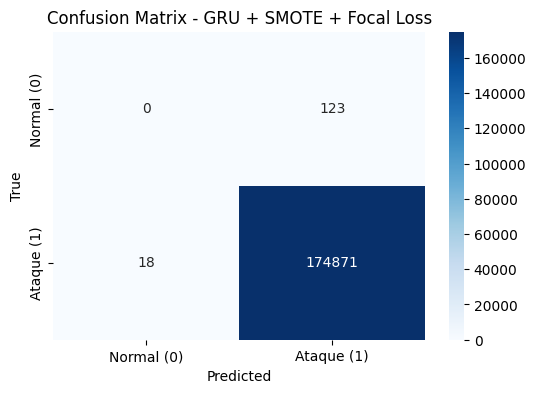

In [37]:
y_proba = model.predict(X_test, batch_size=256)
y_pred = (y_proba > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("F1:", f1_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))

# ============================
# Visualizar matriz de confusión
# ============================
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal (0)","Ataque (1)"], yticklabels=["Normal (0)","Ataque (1)"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GRU + SMOTE + Focal Loss")
plt.show()